In [1]:
import tensorflow as tf
import numpy as np

In [ ]:
import torch

In [ ]:
pip uninstall numpy

In [5]:
from tensorflow import keras

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: SystemError: <built-in method __contains__ of dict object at 0x000001732E833240> returned a result with an error set

In [3]:
pip install tensorflow==1.5

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow==1.5
ERROR: No matching distribution found for tensorflow==1.5


In [5]:
from tensorflow.keras import layers

In [6]:
import matplotlib.pyplot as plt

In [7]:
IMAGE_SIZE =256
BATCH_SIZE =32
CHANNELS = 3
EPOCH = 50

In [8]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
        "PlantVillage",
         shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names 

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset)

68

In [11]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 2 1 0 0 0 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0]


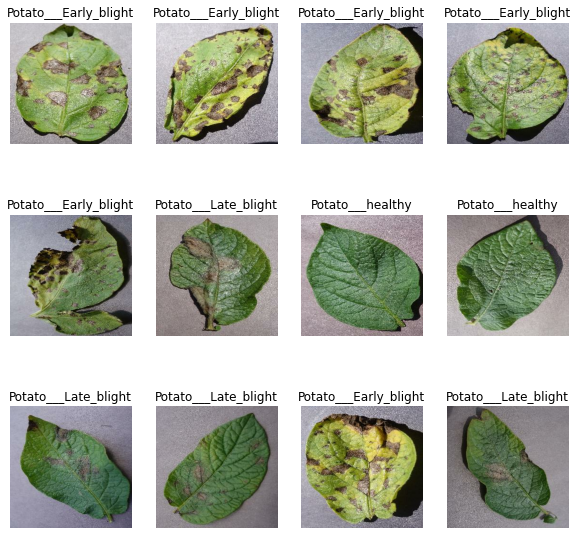

In [12]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
      ax = plt.subplot(3,4,i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8")) 
      plt.title(class_names[label_batch[i]])
      plt.axis("off")


80% ==> training
20%==> 10% validation, 10% test

In [13]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [14]:
train_ds= dataset.take(54)
len(train_ds)

54

In [15]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [16]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed= 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

54

In [22]:
len(val_ds)

6

In [23]:
len(test_ds)

8

In [24]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
resize_and_rescale =tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [26]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [27]:
from tensorflow.keras.models import Model

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
    history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 274s 5s/step - loss: 0.9096 - accuracy: 0.4850 - val_loss: 0.8002 - val_accuracy: 0.5104
Epoch 2/50
54/54 [==============================] - 252s 5s/step - loss: 0.6182 - accuracy: 0.7106 - val_loss: 0.5165 - val_accuracy: 0.7500
Epoch 3/50
54/54 [==============================] - 247s 5s/step - loss: 0.4213 - accuracy: 0.8299 - val_loss: 0.3494 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 2109s 40s/step - loss: 0.3776 - accuracy: 0.8582 - val_loss: 0.4604 - val_accuracy: 0.7969
Epoch 5/50
54/54 [==============================] - 192s 4s/step - loss: 0.2821 - accuracy: 0.8918 - val_loss: 0.4003 - val_accuracy: 0.8333
Epoch 6/50
54/54 [==============================] - 170s 3s/step - loss: 0.1833 - accuracy: 0.9282 - val_loss: 0.5520 - val_accuracy: 0.8229
Epoch 7/50
54/54 [==============================] - 170s 3s/step - loss: 0.1319 - accuracy: 0.9514 - val_loss: 0.3824 - val_accuracy: 0.8438
Epoch 8/50


In [32]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 36s 649ms/step - loss: 0.0256 - accuracy: 0.9961


In [33]:
history

In [34]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

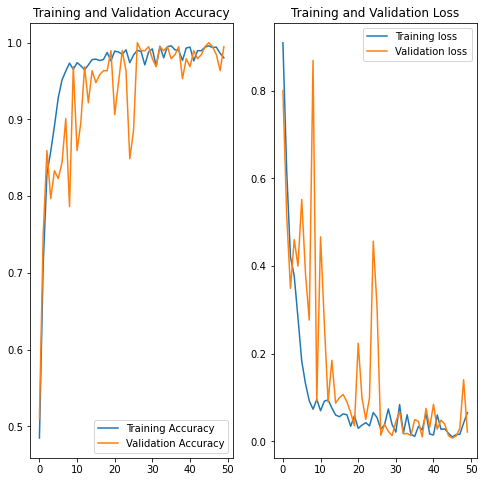

In [40]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label='Training Accuracy')
plt.plot(range(EPOCH), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label='Training loss')
plt.plot(range(EPOCH), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

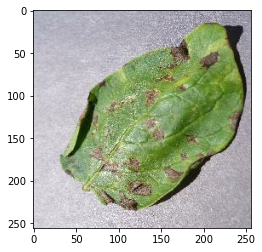

In [41]:
for images_batch, labels_batch in test_ds.take(1):
    plt.imshow(images_batch[0].numpy().astype('uint8'))

In [43]:
for images_batch, labels_batch in test_ds.take(1):
    print(images_batch[0].numpy().astype('uint8'))

[[[146 142 157]
  [149 145 160]
  [151 147 162]
  ...
  [121 110 124]
  [117 106 120]
  [117 106 120]]

 [[163 159 174]
  [163 159 174]
  [160 156 171]
  ...
  [120 109 123]
  [121 110 124]
  [125 114 128]]

 [[172 168 183]
  [171 167 182]
  [165 161 176]
  ...
  [119 108 122]
  [121 110 124]
  [128 117 131]]

 ...

 [[147 141 153]
  [156 150 162]
  [161 155 167]
  ...
  [111  99 111]
  [115 103 115]
  [118 106 118]]

 [[153 147 159]
  [155 149 161]
  [159 153 165]
  ...
  [110  98 110]
  [118 106 118]
  [125 113 125]]

 [[157 151 163]
  [152 146 158]
  [154 148 160]
  ...
  [113 101 113]
  [119 107 119]
  [125 113 125]]]


In [47]:
np.argmax([9.9999964e-01,3.9333537e-07,1.1586251e-18])

0

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


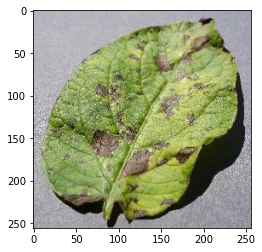

In [48]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image=images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [49]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

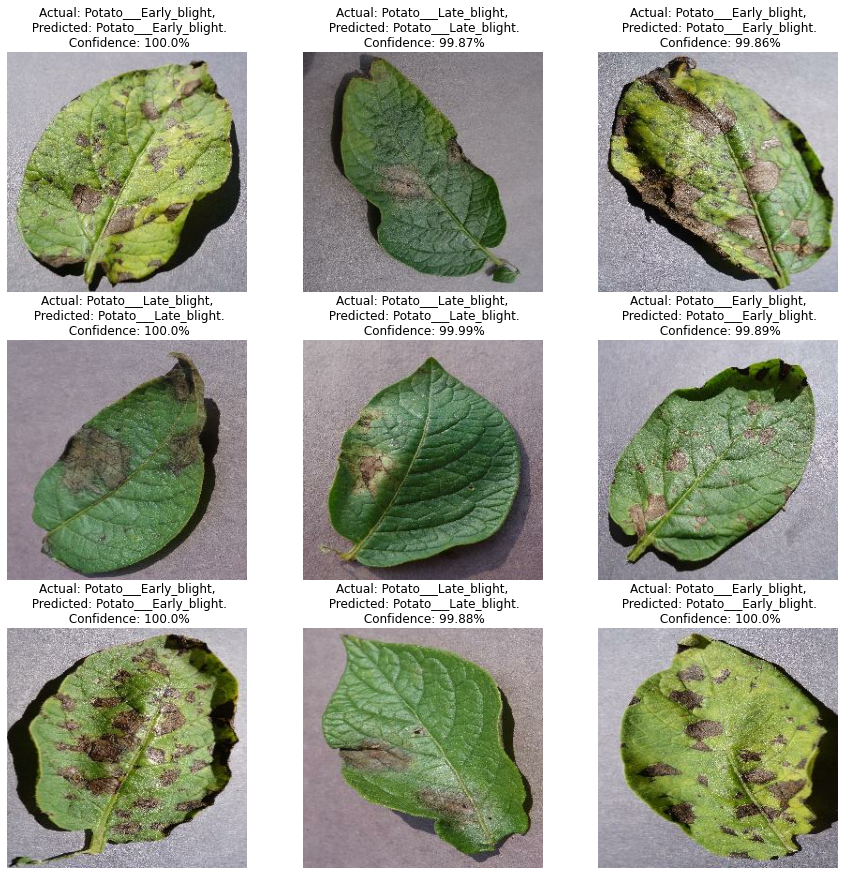

In [55]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i +1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%",)
        plt.axis("off")

In [79]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/5\assets
